In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tqdm

In [8]:
frames = []
cap = cv2.VideoCapture('video.mp4')
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

if not cap.isOpened():
    print("Error opening video file")

for frame_index in tqdm.trange(total_frames, position=0):
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(cv2.resize(frame, (400, 400)))

cap.release()
frames_array = np.array(frames)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2998/2998 [00:11<00:00, 254.93it/s]


In [203]:
def process_image(image, threshold_value=0.7, bottom_value=0.8):
    # Set parameters
    threshold_value = int(threshold_value * 255)
    bottom_value = int(image.shape[0] * bottom_value)
    
    blr_image = cv2.GaussianBlur(image, (5, 5), 0)
    
    # Get channels
    blue_channel = blr_image[:, :, 0]
    green_channel = blr_image[:, :, 1]
    red_channel = blr_image[:, :, 2]

    # Apply threshold to each channel
    _, thresholded_blue = cv2.threshold(blue_channel, threshold_value, 1, cv2.THRESH_BINARY)
    _, thresholded_green = cv2.threshold(green_channel, threshold_value, 1, cv2.THRESH_BINARY)
    _, thresholded_red = cv2.threshold(red_channel, threshold_value, 1, cv2.THRESH_BINARY)
    
    max_image = np.minimum.reduce([thresholded_blue, thresholded_green, thresholded_red])
    max_image = cv2.resize(max_image[bottom_value:], (image.shape[1], 200))
    edg_image = cv2.Scharr(max_image, cv2.CV_64F, 1, 0)
    edg_image[edg_image != 0] = 1
    border_array = edg_image[100:].mean(axis=0)
    return border_array

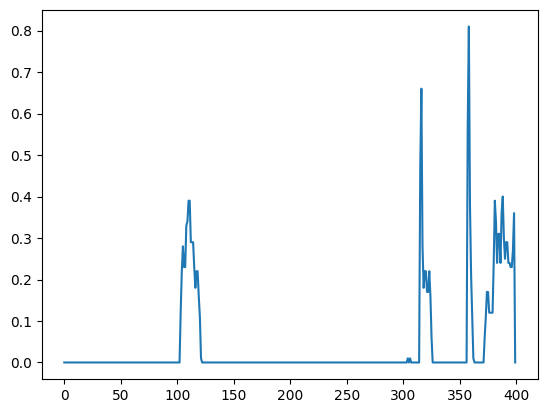

In [204]:
plt.plot(process_image(image, threshold_value=0.7, bottom_value=0.9))

In [740]:
cap = cv2.VideoCapture('video.mp4')
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
threshold_value=0.7
bottom_value=0.8
threshold_value = int(threshold_value * 255)
bottom_value = int(image.shape[0] * bottom_value)
    
    
for frame_index in range(total_frames):
    ret, frame = cap.read()
    if ret == True:
        frame = cv2.resize(frame, (400, 400))
        frame = cv2.normalize(frame, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        # Display the resulting frame
        cv2.imshow('Frame', frame)

        # Get channels
        blue_channel = frame[:, :, 0] * 255
        green_channel = frame[:, :, 1] * 255
        red_channel = frame[:, :, 2] * 255

        # Apply threshold to each channel
        _, thresholded_blue = cv2.threshold(blue_channel, threshold_value, 1, cv2.THRESH_BINARY)
        _, thresholded_green = cv2.threshold(green_channel, threshold_value, 1, cv2.THRESH_BINARY)
        _, thresholded_red = cv2.threshold(red_channel, threshold_value, 1, cv2.THRESH_BINARY)

        max_image = np.minimum.reduce([thresholded_blue, thresholded_green, thresholded_red])
        pts1 = np.float32([[170, 280], [230, 280], [0, 400], [400, 400]])
        pts2 = np.float32([[0, 0], [400, 0], [0, 800], [400, 800]])

        # Apply Perspective Transform Algorithm
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        result = cv2.warpPerspective(max_image, matrix, (400, 800))
        kimage = cv2.filter2D(result, -1, create_vertical_line_filter(size=25, line_width=3))
        _, kimage = cv2.threshold(kimage, 0.25, 1, cv2.THRESH_BINARY)
        
        cv2.imshow('brd_image', kimage * 255)

        # Press Q on keyboard to  exit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
 
  # Break the loop
    else: 
        break

# When everything done, release the video capture object
cap.release()
 
# Closes all the frames
cv2.destroyAllWindows()

In [215]:
cv2.destroyAllWindows()

In [720]:
def average(image, lines):
    left = []
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        y_int = parameters[1]
        left.append((slope, y_int))
            
    left_avg = np.average(left, axis=0)
    left_line = make_points(image, left_avg)
    return np.array([left_line])

def make_points(image, average): 
    slope, y_int = average 
    y1 = image.shape[0]
    y2 = int(y1 * (3/5))
    x1 = int((y1 - y_int) // slope)
    x2 = int((y2 - y_int) // slope)
    return np.array([x1, y1, x2, y2])

def display_lines(image, lines):
    lines_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line
            cv2.line(lines_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
    return lines_image

In [721]:
# lines = cv2.HoughLinesP(np.uint8(kimage * 255), rho=2, theta=np.pi/180, threshold=100, minLineLength=400, maxLineGap=200)

In [738]:
copy = np.uint8(kimage * 255)
lines = cv2.HoughLinesP(copy, rho=2, theta=np.pi/180, threshold=5, minLineLength=100, maxLineGap=0)
averaged_lines = average(copy, lines)
black_lines = display_lines(copy, averaged_lines)
lanes = cv2.addWeighted(copy, 0.8, black_lines, 1, 1)

C:\Users\Artem\AppData\Local\Temp\ipykernel_19720\2987765768.py:3: RankWarning: Polyfit may be poorly conditioned
  averaged_lines = average(copy, lines)
C:\Users\Artem\AppData\Local\Temp\ipykernel_19720\2987765768.py:3: RankWarning: Polyfit may be poorly conditioned
  averaged_lines = average(copy, lines)


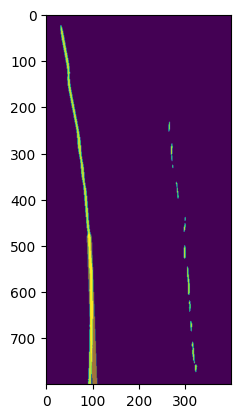

In [739]:
plt.imshow(kimage)
plt.imshow(lanes,alpha=0.5)

In [588]:
def create_vertical_line_filter(size, line_width):
    # Ensure the size and line width are odd to have a center
    if size % 2 == 0:
        size += 1
    if line_width % 2 == 0:
        line_width += 1

    # Create a kernel with all zeros
    kernel = np.zeros((size, size), dtype=np.float32)
    
    # Calculate start and end points for the line
    start = size // 2 - line_width // 2
    end = start + line_width

    # Set the line pixels to 1
    kernel[:, start:end] = 1
    
    kernel[: size // 4 - 1, (size // 2 - line_width + 1) : (size // 2 + line_width)] = 1
    kernel[1 - size // 4 :, (size // 2 - line_width + 1) : (size // 2 + line_width)] = 1
    kernel = cv2.blur(kernel, (5, 5))
    kernel = kernel / kernel.sum() - 1 / kernel.size
    return kernel

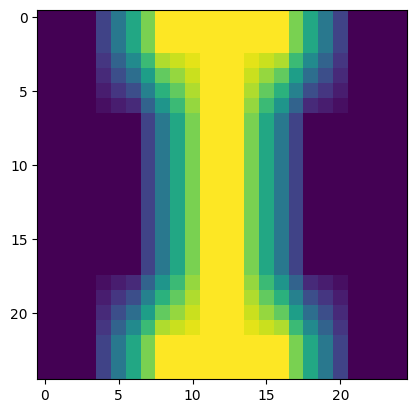

In [589]:
base_filter = create_vertical_line_filter(25, 7)

plt.imshow(base_filter)

In [266]:
def local_normalize(image, kernel_size=3):
    # Ensure kernel size is odd
    if kernel_size % 2 == 0:
        kernel_size += 1

    # Pad the image to handle the borders
    pad_size = kernel_size // 2
    padded_image = cv2.copyMakeBorder(image, pad_size, pad_size, pad_size, pad_size, cv2.BORDER_REFLECT)

    # Prepare an empty image to store the results
    normalized_image = np.zeros_like(image)

    # Iterate over each pixel in the image
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # Extract the neighborhood
            neighborhood = padded_image[i:i+kernel_size, j:j+kernel_size]

            # Find the min and max values in the neighborhood
            min_val = np.min(neighborhood)
            max_val = np.max(neighborhood)

            # Normalize the pixel
            if max_val - min_val != 0:
                normalized_image[i, j] = (image[i, j] - min_val) / (max_val - min_val)
            else:
                normalized_image[i, j] = image[i, j]

    return normalized_image

In [267]:
# Assuming 'max_image' is your input image
normalized_max_image = local_normalize(max_image, kernel_size=3)

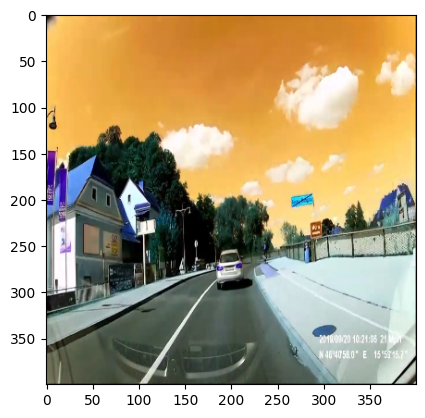

In [268]:
plt.imshow(image)

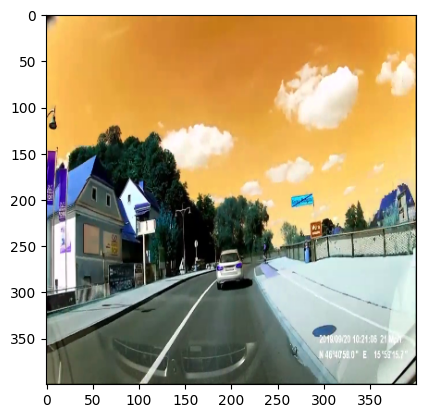

In [306]:
nimage = cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
plt.imshow(nimage)

In [333]:
def split_into_squares(image, square_size):
    squares = []
    height, width = image.shape[:2]

    for i in range(0, height, square_size):
        for j in range(0, width, square_size):
            square = image[i:i+square_size, j:j+square_size]
            square = cv2.normalize(square, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            squares.append(square)

    return squares

def compose_from_squares(squares, original_shape, square_size):
    height, width = original_shape[:2]
    composed_image = np.zeros(original_shape, dtype=squares[0].dtype)

    idx = 0
    for i in range(0, height, square_size):
        for j in range(0, width, square_size):
            composed_image[i:i+square_size, j:j+square_size] = squares[idx]
            idx += 1

    return composed_image

# Assuming 'max_image' is your input image
square_size = 25  # Define the size of each square

# Split the image into squares
squares = split_into_squares(image[:, :, 0], square_size)

# Compose the image back from the squares
composed_image = compose_from_squares(squares, max_image.shape, square_size)

# Display or save the 

In [413]:
k_size = 7
c_size = k_size // 3
custom_filter = create_vertical_line_filter(size=k_size, line_width=c_size)
custom_filter

array([[-0.02040816, -0.02040816,  0.02721089,  0.02721089,  0.02721089,
        -0.02040816, -0.02040816],
       [-0.02040816, -0.02040816,  0.02721089,  0.02721089,  0.02721089,
        -0.02040816, -0.02040816],
       [-0.02040816, -0.02040816,  0.02721089,  0.02721089,  0.02721089,
        -0.02040816, -0.02040816],
       [-0.02040816, -0.02040816,  0.02721089,  0.02721089,  0.02721089,
        -0.02040816, -0.02040816],
       [-0.02040816, -0.02040816,  0.02721089,  0.02721089,  0.02721089,
        -0.02040816, -0.02040816],
       [-0.02040816, -0.02040816,  0.02721089,  0.02721089,  0.02721089,
        -0.02040816, -0.02040816],
       [-0.02040816, -0.02040816,  0.02721089,  0.02721089,  0.02721089,
        -0.02040816, -0.02040816]], dtype=float32)

In [494]:
k_size = 25
c_size = k_size // 3

custom_filter = create_vertical_line_filter(size=k_size, line_width=c_size)

pts1 = np.float32([[170, 280], [230, 280], [0, 400], [400, 400]])
pts2 = np.float32([[0, 0], [400, 0], [0, 800], [400, 800]])

# Apply Perspective Transform Algorithm
matrix = cv2.getPerspectiveTransform(pts1, pts2)
result = cv2.warpPerspective(image / 255, matrix, (400, 800))
kimage = cv2.filter2D(result, -1, create_vertical_line_filter(size=25, line_width=3))
_, kimage = cv2.threshold(kimage, 0.2, 1, cv2.THRESH_BINARY)

plt.imshow(kimage)

In [485]:
kimage.max()

100

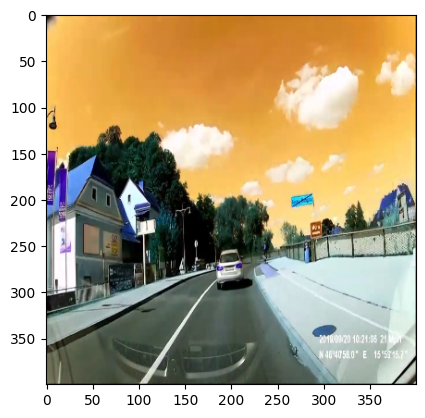

In [445]:
plt.imshow(image)